# Deep learning with Keras: part 2

## Goal: Learn to train neural networks & experiment with example code

## C) Sinogram inpainting

#### First import all the necessary packages. If you get an error here, make sure have actually installed the package!

In [ ]:
import cv2
import glob

import numpy as np
import scipy.io

from tensorflow.keras import Model, layers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, BatchNormalization, Convolution2D, UpSampling2D, Dense, MaxPooling2D, concatenate
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

import skimage
from skimage.measure import block_reduce

import matplotlib.pyplot as plt

from random import randrange

%matplotlib inline 

#### Load the training data from directory (mat-files)

https://www.dropbox.com/scl/fo/rk6l1fi2pjfsupplyc4ix/h?rlkey=59c0m80y6894f5tmn94tgtb4n&dl=0

In [ ]:
# Desired dimensions for data
N  = 32  # sinogram column
M  = 16  # input rows
M2 = 256 # outputrows
X  = 1   # color channels

# Import training input
train_input = []
files       = sorted(glob.glob("sinogram_train/*11.mat"))

for myFile in files:
    print(myFile)
    mat    = scipy.io.loadmat(myFile)
    matrix = mat['Rmu_big']
    
    # resize matrix
    matrix_resized = cv2.resize(matrix, dsize=(N,M), interpolation=cv2.INTER_CUBIC)
    
    # pick every 8th row of matrix
    #matrix_resized = matrix[::16]
    
    train_input.append(matrix_resized)  
train_input = np.array(train_input)

# Import training output (ground truth)
train_gt = []
files    = sorted(glob.glob("sinogram_train/*11.mat"))

for myFile in files:
    print(myFile)
    mat    = scipy.io.loadmat(myFile)
    matrix = mat['Rmu_big']
    
    # resize matrix
    matrix_resized = cv2.resize(matrix, dsize=(N,M2), interpolation=cv2.INTER_CUBIC)
    
    train_gt.append(matrix_resized)  
train_gt = np.array(train_gt)

In [ ]:
# Show training set size

print(train_input.shape) 
print(train_gt.shape)

#### Pre-process training data

In [21]:
# Normalize data

print('Input value range:')
min_input = np.amin(train_input)
max_input = np.amax(train_input)
print(min_input)
print(max_input)
train_input = (train_input - min_input) / (max_input - min_input)

print('Output value range:')
min_output = np.amin(train_gt)
max_output = np.amax(train_gt)
print(min_output)
print(max_output)
train_gt = (train_gt - min_output) / (max_output - min_output)

print('Normalized input value range:')
print(np.amin(train_gt))
print(np.amax(train_gt))

print('Normalized output value range:')
print(np.amin(train_input))
print(np.amax(train_input))

Input value range:
-126.03942896815641
0.7323451061579411
Output value range:
-128.32595407904975
0.9413320530448435
Normalized input value range:
0.0
1.0
Normalized output value range:
0.0
1.0


470
Example of input
0.6021271937182757
0.9956502387910148


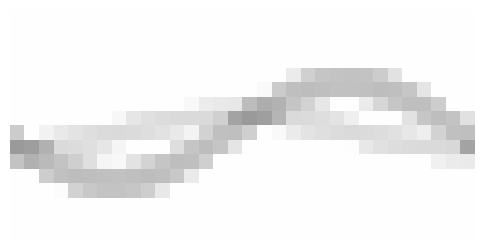

Example of output
0.6078686615064582
0.9957849733293679


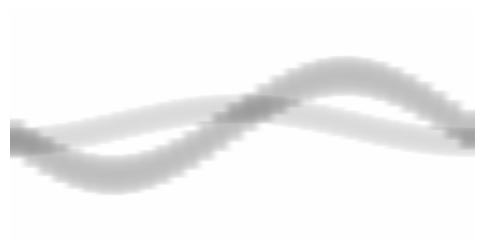

In [22]:
# Sanity check: take a look at training data

iii = randrange(5000)
print(iii)

plt.rcParams["figure.figsize"] = (6,3)
print('Example of input')
im = train_input[iii,:,:]
print(np.amin(im))
print(np.amax(im))
plt.imshow(train_input[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()


plt.rcParams["figure.figsize"] = (6,3)
print('Example of output')
im3 = train_gt[iii,:,:]
print(np.amin(im3))
print(np.amax(im3))
plt.imshow(train_gt[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

In [17]:
# Create a validation set for training

valid_size = 1000  
train_gt, valid_gt       = train_test_split(train_gt, test_size=valid_size, shuffle=False)  
train_input, valid_input = train_test_split(train_input, test_size=valid_size, shuffle=False)  

print(np.amin(train_gt))
print(np.amax(train_gt))

print(np.amin(train_input))
print(np.amax(train_input))

In [18]:
# Sanity check: take a look at validation data

plt.rcParams["figure.figsize"] = (3,3)

iii = randrange(valid_size)
print(iii)

print('Example of input')
im = valid_input[iii,:,:]
print(np.amin(im))
print(np.amax(im))
plt.imshow(valid_input[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

print('Example of output')
im3 = valid_gt[iii,:,:]
print(np.amin(im3))
print(np.amax(im3))
plt.imshow(valid_gt[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

In [19]:
# Let's reshape the image data to the format the neural network expects for training

train_gt    = train_gt.reshape(-1,N,M2,X)
train_input = train_input.reshape(-1,N,M,X)

valid_gt    = valid_gt.reshape(-1,N,M2,X)
valid_input = valid_input.reshape(-1,N,M,X)

print(train_gt.shape)
print(train_input.shape)

#### Neural network architecture: fully connected

In [116]:
def make_basic_network():  
    inputs = Input(shape=(N,M,X))
    
    x = Dense(10, activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    x = Dense(20, activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(30, activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(40, activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(1, activation='sigmoid')(x)

    funcmodel = Model(inputs, x)
    
    funcmodel.compile(optimizer='adadelta', loss='MSE')
    
    return funcmodel

#### Neural network architecture: convolutional neural network

In [28]:
def make_CNN():
    inputs = Input(shape=(N,M,X))
    
    u1 = Convolution2D(128, 3, activation='relu', padding='same')(inputs)
    u1 = BatchNormalization()(u1)
    
    u2 = Convolution2D(64, 3, activation='relu', padding='same')(u1)
    u2 = BatchNormalization()(u2)
    
    output = Convolution2D(X, 1, activation='sigmoid', padding='same')(u2)
    
    neural_network = Model(inputs, output)
    neural_network.compile(optimizer='adam', loss='MSE')
    
    return neural_network

#### Neural network architecture: Unet

In [106]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(N,M,X))
    
    d1 = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
    d1 = BatchNormalization()(d1)
    d2 = MaxPooling2D(padding='same')(d1)
    
    d3 = Convolution2D(128, 3, activation='relu', padding='same')(d2)
    d3 = BatchNormalization()(d3)
    encoded = MaxPooling2D(padding='same')(d3)    
    
    # decoding
    u1 = Convolution2D(128, 3, activation='relu', padding='same')(encoded)
    u1 = BatchNormalization()(u1)
    u2 = UpSampling2D()(u1)
    u2 = concatenate([u2, d3])
    
    u3 = Convolution2D(64, 3, activation='relu', padding='same')(u2)
    u3 = BatchNormalization()(u3)
    u4 = UpSampling2D()(u3)
    u4 = concatenate([u4, d1])
    
    decoded = Convolution2D(X, 1, activation='sigmoid', padding='same')(u4)
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='MSE')
    
    return autoencoder

In [117]:
# Create model

neural_network = make_basic_network()
#neural_network = make_CNN()
#neural_network = make_convolutional_autoencoder()

neural_network.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 dense_5 (Dense)             (None, 64, 64, 10)        20        
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 10)       40        
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 64, 64, 20)        220       
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 20)       80        
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 64, 64, 30)        630 

#### Train neural network

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=6) #early stopping

# train
history = neural_network.fit(train_input, train_gt, epochs=3, batch_size=5, 
                             validation_data=(valid_input, valid_gt), callbacks=[es])

Epoch 1/3
644/800 [=======================>......] - ETA: 6s - loss: 0.0740

In [109]:
# Save model
neural_network.save('models/ellipse_deblurring_unet')

INFO:tensorflow:Assets written to: models/ellipse_deblurring_unet/assets


INFO:tensorflow:Assets written to: models/ellipse_deblurring_unet/assets


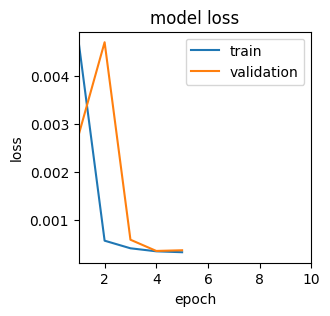

In [32]:
# summarize history for loss

loss_values = history.history['loss']
epochs      = range(1,len(loss_values)+1)

plt.plot(epochs,loss_values)
plt.plot(epochs,history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.xlim([1, 10])
plt.savefig('figures/loss_ellipse_superresolution_test1.png')
plt.show()

#### Test results with unseen data

In [ ]:
# Load model
autoencoder = models.load_model('models/ellipse_deblurring_CNN')

In [100]:
# Import testing input
test_input = []
files      = sorted(glob.glob("ellipses_test/*1.mat"))

sigma = 3.0 # blurring 

for myFile in files:
    print(myFile)
    mat    = scipy.io.loadmat(myFile)
    matrix = mat['ph']
    
    # resize matrix
    matrix_resized = cv2.resize(matrix, dsize=(M,M), interpolation=cv2.INTER_CUBIC)
    
    # apply gaussian blur
    matrix_blurred = skimage.filters.gaussian(matrix_resized, sigma=(sigma,sigma), truncate=3.5, channel_axis=-1)
    
    test_input.append(matrix_blurred)  
test_input = np.array(test_input)

# Import testing output (ground truth)
test_gt = []
files   = sorted(glob.glob("ellipses_test/*1.mat"))

for myFile in files:
    print(myFile)
    mat    = scipy.io.loadmat(myFile)
    matrix = mat['ph']
    
    # resize matrix
    matrix_resized = cv2.resize(matrix, dsize=(N,N), interpolation=cv2.INTER_CUBIC)
    
    test_gt.append (matrix_resized)
test_gt = np.array(test_gt)

ellipses_test/ph0001.mat
ellipses_test/ph0001.mat


In [110]:
# Normalize data

print('Input value range:')
min_input = np.amin(test_input)
max_input = np.amax(test_input)
print(min_input)
print(max_input)
test_input = (test_input - min_input) / (max_input - min_input)

print('Output value range:')
min_output = np.amin(test_gt)
max_output = np.amax(test_gt)
print(min_output)
print(max_output)
test_gt = (test_gt - min_output) / (max_output - min_output)

print('Normalized input value range:')
print(np.amin(test_gt))
print(np.amax(test_gt))

print('Normalized output value range:')
print(np.amin(test_input))
print(np.amax(test_input))

print(test_gt.shape)
print(test_input.shape)

test_gt     = test_gt.reshape(-1,N,N,X)
test_input  = test_input.reshape(-1,M,M,X)

print(test_gt.shape)
print(test_input.shape)

Input value range:
0.0
1.0
Output value range:
0.0
1.0
Normalized input value range:
0.0
1.0
Normalized output value range:
0.0
1.0
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)


In [119]:
# Predict results on test set

test_gt_decoded = neural_network.predict(test_input)
print(test_gt_decoded.shape)

1/1 [==============================] - 1s 508ms/step
(1, 64, 64, 1)


0
Network input
0.0
1.0


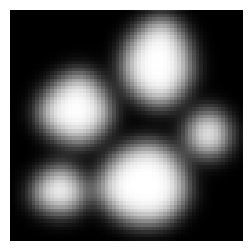

Network output
0.32870263
0.9997375


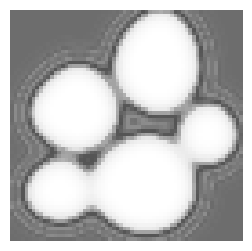

Ground truth
0.0
1.0


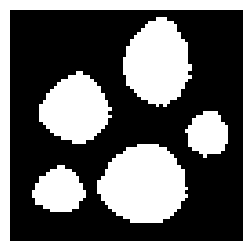

In [120]:
# We pass the testing inputs to the neural network to see the restored data

iii = 0
print(iii)

print('Network input')
im3 = test_input[iii,:,:]
print(np.amin(im3))
print(np.amax(im3))
plt.imshow(test_input[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

print('Network output')
im3 = test_gt_decoded[iii,:,:]
print(np.amin(im3))
print(np.amax(im3))
plt.imshow(test_gt_decoded[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

print('Ground truth')
im3 = test_gt[iii,:,:]
print(np.amin(im3))
print(np.amax(im3))
plt.imshow(test_gt[iii,:,:], cmap="gray",vmin=0, vmax=1,aspect='auto')
plt.axis('off')
plt.show()

In [105]:
# Save whole test set as mat.-files

for iii in range(len(test_gt_decoded)):
    mydata   = test_gt_decoded[iii,:,:,:]
    filename = "results/ellipse_deblurring_%04.f.mat" % iii
    savemat(filename, {'mydata': mydata})
    print(iii)

0


## To do: Experiment!
#### Try out different hyperparameters for the neural networks. What yields the best results? Things to experiment with:

- neural network type (compare number of learned parameters!)
- number of neurons in each layer (make sure dimensions match the data!)
- how many epochs necessary to reach convergence?
- loss functions (mean squared error, custom loss functions?) 
- activation functions (relu, sigmoid, tanh...)
- to use batch normalization or not?
- optimizer (adam, adadelta, rmsprop...)